## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBacken.figure_format = 'retina'
import seaborn as sns
import statsmodels.api as sm

## Importing cleaned dataset

In [2]:
# Importing cleaned dataset and dropping old index

retail = pd.read_csv('./dataset/retail_clean.csv')
retail = retail.drop('Unnamed: 0', axis=1)
retail

,Date,Weekday,Hour,Product line,Quantity,Total,Rating
0,2019-01-05 13:08:00,Weekend,13,Health and beauty,7,548.9715,9.1
1,2019-03-08 10:29:00,Workday,10,Electronic accessories,5,80.2200,9.6
2,2019-03-03 13:23:00,Weekend,13,Home and lifestyle,7,340.5255,7.4
3,2019-01-27 20:33:00,Weekend,20,Health and beauty,8,489.0480,8.4
4,2019-02-08 10:37:00,Workday,10,Sports and travel,7,634.3785,5.3
...,...,...,...,...,...,...,...
995,2019-01-29 13:46:00,Workday,13,Health and beauty,1,42.3675,6.2
996,2019-03-02 17:16:00,Weekend,17,Home and lifestyle,10,NaN,4.4
997,2019-02-09 13:22:00,Weekend,13,Food and beverages,1,33.4320,7.7
998,2019-02-22 15:33:00,Workday,15,Home and lifestyle,1,69.1110,4.1


## First Insights

In [3]:
retail.describe()

,Hour,Quantity,Total,Rating
count,1000.000000,1000.000000,991.000000,1000.00000
mean,14.910000,5.510000,316.604752,6.97270
std,3.186857,2.923431,237.709589,1.71858
min,10.000000,1.000000,10.678500,4.00000
25%,12.000000,3.000000,122.167500,5.50000
50%,15.000000,5.000000,252.756000,7.00000
75%,18.000000,8.000000,464.667000,8.50000
max,20.000000,10.000000,951.825000,10.00000


- The mean is most of the time closed to the median which shows that the data is concentrated around the mean.
- Unit price (in USD): between 10.08 to 99.96 with an average of 55.67
- Quantity: between 1 and 10 with a median of 5 - the buyers don't buy many articles at once
- Total spent (in USD): between 10ish to 951.82 with an average around 316
- Ratings: between 4 and 10 with a mean of 6.97

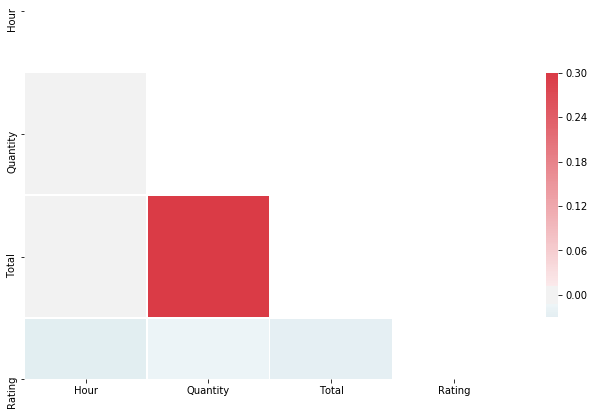

In [4]:
corr = retail.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

No interesting insights from correlation matrix

## Understanding Customer Behavior based on Time Series Data

In [5]:
# Pivot table (mean)
pivot = pd.pivot_table(index = 'Hour', values = ['Quantity', 'Rating', 'Total'], columns = 'Weekday',
                            data = retail, aggfunc = 'mean', margins=True)
pivot = pivot.iloc[:, :-1]
pivot

Quantity                        Rating                      \
Weekday   Weekend   Workday       All   Weekend   Workday       All   
Hour                                                                  
10       5.481481  5.187500  5.274725  6.507407  7.357812  7.105495   
11       6.826087  5.018182  5.551282  6.700000  6.909091  6.847436   
12       5.827586  5.304348  5.506667  7.689655  7.271739  7.433333   
13       5.812500  5.568627  5.555556  7.415625  7.041176  7.195062   
14       6.541667  5.530612  5.805556  7.312500  6.691837  6.900000   
15       4.913043  5.290323  5.188235  6.300000  7.046774  6.844706   
16       4.800000  5.446809  5.107692  6.965000  6.851064  6.840000   
17       6.434783  5.341463  5.666667  6.773913  6.965854  6.936508   
18       4.969697  5.186047  5.092105  7.148485  7.395349  7.288158   
19       6.150000  5.661017  5.858586  6.642500  6.710169  6.682828   
20       4.913043  5.720930  5.439394  6.834783  7.076744  6.992424   
All      5.684746  5.347122  5.464160  6.955932  7.025540  7.001410   

              Total              
Weekday     Weekend     Workday  
Hour                             
10       272.716111  326.262727  
11       444.507913  275.430655  
12       332.381121  286.706609  
13       339.037125  308.094000  
14       417.416563  344.899625  
15       267.516261  325.333863  
16       264.789000  323.971109  
17       373.484523  295.239000  
18       314.425045  265.594081  
19       377.025600  346.751110  
20       242.679652  339.652535  
All      334.008346  313.906263

- Quantity: uniformer during wordays
- Rating: overall higher on the wordays
- Total: higher average on the weekend

### Peak Hours Workday VS Weekend

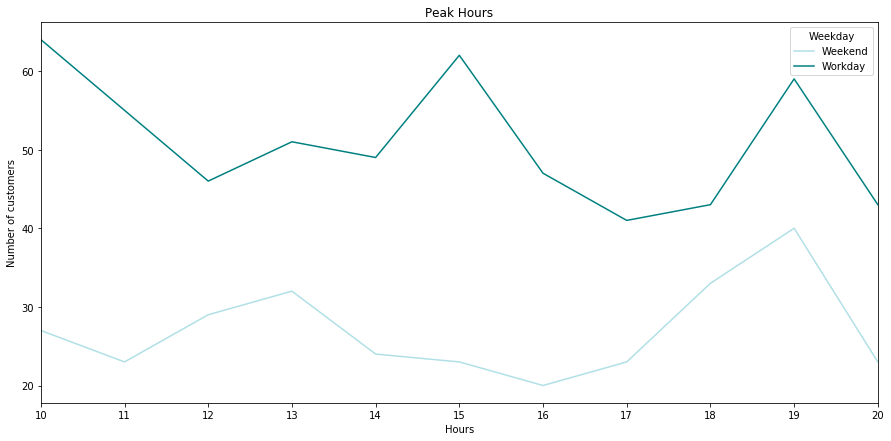

In [6]:
fig, ax = plt.subplots(figsize=(15,7))

retail.groupby(['Weekday'])['Hour'].value_counts().unstack().T.plot(ax=ax, color = ['powderblue', 'teal'])
plt.xticks(np.arange(10, 21))
plt.xlabel('Hours')
plt.ylabel('Number of customers')
plt.title('Peak Hours')
plt.show()

Workday:
- Rush hour: peak at 1pm and then at 7pm
- Slow hour: 4pm

Weekend: 
- Rush hour: peak at 3pm and then at 7pm
- Slow hour: 5pm

### Product line and quantity

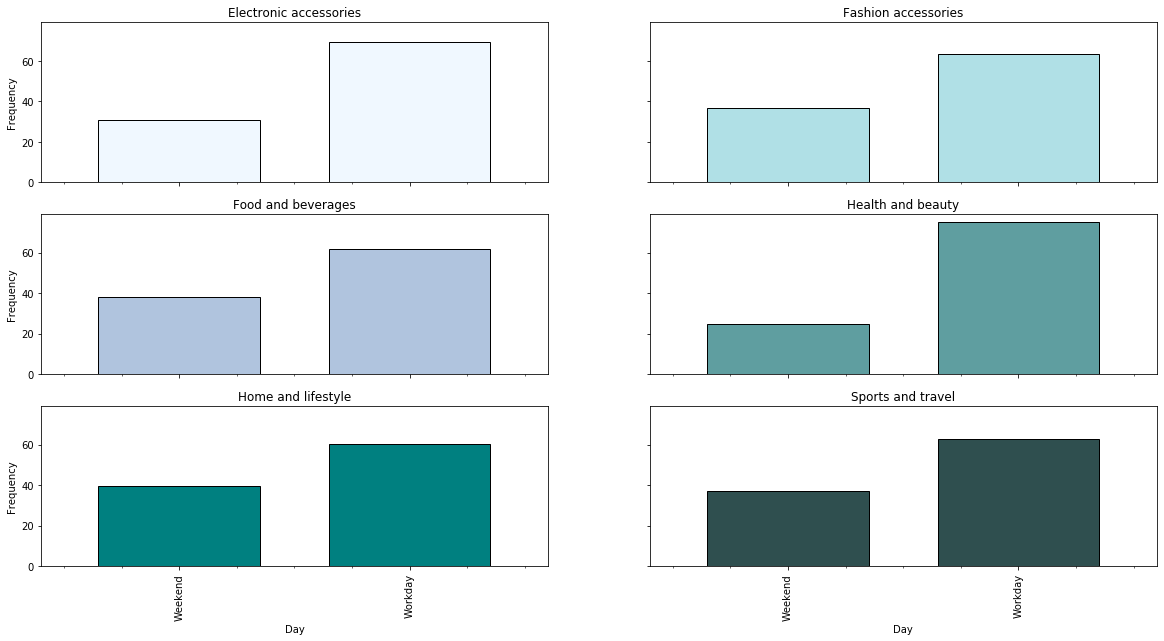

In [7]:
# Product sale VS weekday (in %)
product_day = pd.crosstab(index = retail['Weekday'], columns = retail['Product line'], normalize='columns')\
    .round(4)*100
product_day

fig, axs = plt.subplots(nrows=3, ncols=2, figsize = (20, 25), sharex = True, sharey = True)

product_day['Electronic accessories'].T.plot.bar(color = 'aliceblue'
                           , edgecolor= 'black', width = 0.7, ax=axs[0, 0])
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Electronic accessories')

product_day['Fashion accessories'].T.plot.bar(color = 'powderblue'
                           , edgecolor= 'black', figsize=(20,10), width = 0.7, ax=axs[0, 1])
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Fashion accessories')

product_day['Food and beverages'].T.plot.bar(color = 'lightsteelblue'
                           , edgecolor= 'black', width = 0.7, ax=axs[1, 0])
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Food and beverages')

product_day['Health and beauty'].T.plot.bar(color = 'cadetblue'
                           , edgecolor= 'black', width = 0.7, ax=axs[1, 1])
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Health and beauty')

product_day['Home and lifestyle'].T.plot.bar(color = 'teal'
                           , edgecolor= 'black', width = 0.7, ax=axs[2, 0])
axs[2, 0].set_xlabel('Day')
axs[2, 0].set_ylabel('Frequency')
axs[2, 0].set_title('Home and lifestyle')

product_day['Sports and travel'].T.plot.bar(color = 'darkslategrey'
                           , edgecolor= 'black', width = 0.7, ax=axs[2, 1])
axs[2, 1].set_xlabel('Day')
axs[2, 1].set_ylabel('Frequency')
axs[2, 1].set_title('Sports and travel')

plt.show()

In [8]:
# Product sale VS Hour (in %)
product = pd.pivot_table(index = ['Weekday', 'Hour'], columns = 'Product line', values = 'Quantity',
                            data = retail, aggfunc = 'count', fill_value = '-')
product

Product line  Electronic accessories  Fashion accessories  Food and beverages  \
Weekday Hour                                                                    
Weekend 10                       1.0                  3.0                 7.0   
        11                       4.0                  3.0                 4.0   
        12                       5.0                  7.0                 5.0   
        13                       4.0                  7.0                 3.0   
        14                       3.0                  6.0                 5.0   
        15                       3.0                  5.0                 3.0   
        16                       1.0                  2.0                 5.0   
        17                       4.0                  3.0                 2.0   
        18                      12.0                  7.0                 5.0   
        19                       7.0                  5.0                10.0   
        20                       3.0                  7.0                 5.0   
Workday 10                      14.0                  9.0                11.0   
        11                      12.0                  9.0                 4.0   
        12                       8.0                  9.0                 4.0   
        13                       6.0                  8.0                 8.0   
        14                      11.0                  7.0                 4.0   
        15                       9.0                 10.0                12.0   
        16                      10.0                  7.0                 9.0   
        17                       9.0                  8.0                 4.0   
        18                       6.0                  9.0                 7.0   
        19                       8.0                 16.0                12.0   
        20                      12.0                  3.0                12.0   

Product line  Health and beauty  Home and lifestyle Sports and travel  
Weekday Hour                                                           
Weekend 10                  1.0                 9.0                 6  
        11                  1.0                 7.0                 4  
        12                  2.0                 6.0                 4  
        13                  6.0                 5.0                 7  
        14                  4.0                 4.0                 2  
        15                  4.0                 4.0                 4  
        16                  1.0                 3.0                 8  
        17                  3.0                 8.0                 3  
        18                  3.0                 2.0                 4  
        19                  3.0                 5.0                10  
        20                  5.0                 3.0                 -  
Workday 10                 13.0                 8.0                 9  
        11                  7.0                11.0                12  
        12                 12.0                 6.0                 7  
        13                  9.0                11.0                 9  
        14                 12.0                 4.0                11  
        15                  8.0                13.0                10  
        16                  7.0                 5.0                 9  
        17                  5.0                 8.0                 7  
        18                  9.0                 7.0                 5  
        19                 10.0                 6.0                 7  
        20                  8.0                 6.0                 2

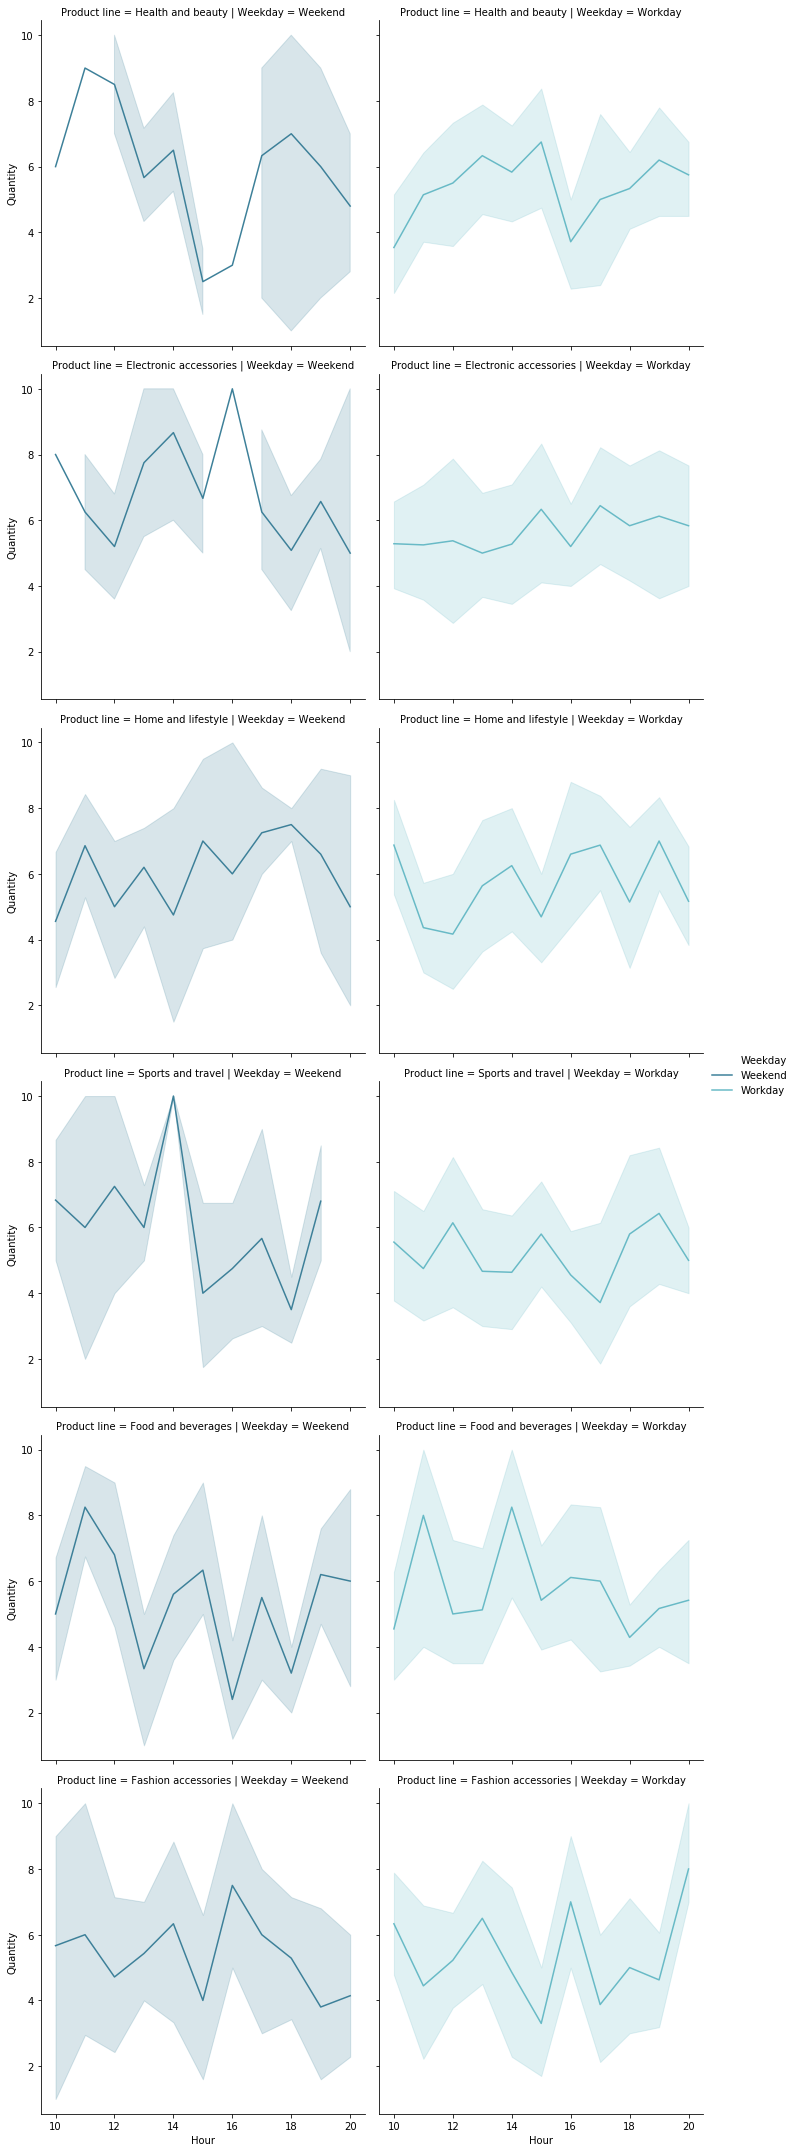

In [9]:
palette = sns.color_palette("GnBu_d", 2)
sns.relplot(x = 'Hour',  y = 'Quantity', col= 'Weekday', row = 'Product line', kind="line", 
             hue="Weekday",data =retail, palette = palette)
plt.show()

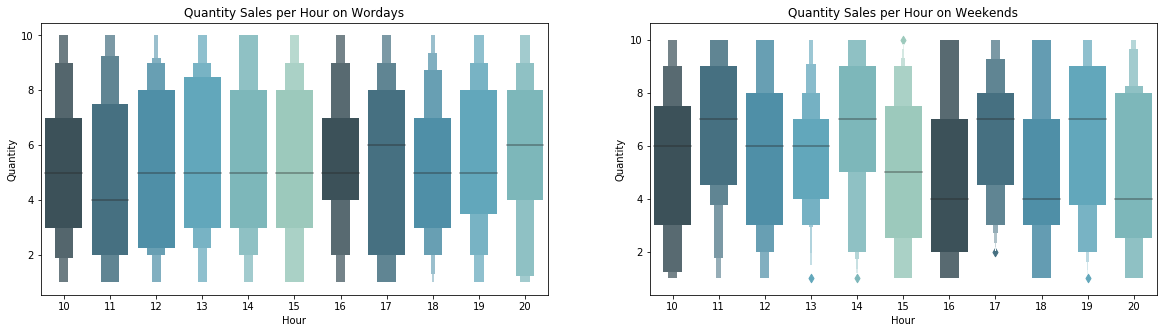

<Figure size 720x360 with 0 Axes>

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (20, 5), sharex = True)

work = retail.loc[retail['Weekday'] == 'Workday']
we = retail.loc[retail['Weekday'] == 'Weekend']

plt.figure(figsize=(10,5))
palette = sns.color_palette("GnBu_d")
sns.boxenplot(x = 'Hour', y = 'Quantity', data = work, palette = palette, 
              ax=axs[0]).set_title('Quantity Sales per Hour on Wordays')
sns.boxenplot(x = 'Hour', y = 'Quantity', data = we, palette = palette, 
              ax=axs[1]).set_title('Quantity Sales per Hour on Weekends')
plt.show()

### Total

In [11]:
total = pd.pivot_table(index = 'Hour', values = 'Total', columns = 'Weekday', 
                            data = retail, aggfunc = 'mean')
total

Weekday,Weekend,Workday
Hour,,
10,272.716111,326.262727
11,444.507913,275.430655
12,332.381121,286.706609
13,339.037125,308.094000
14,417.416563,344.899625
15,267.516261,325.333863
16,264.789000,323.971109
17,373.484523,295.239000
18,314.425045,265.594081


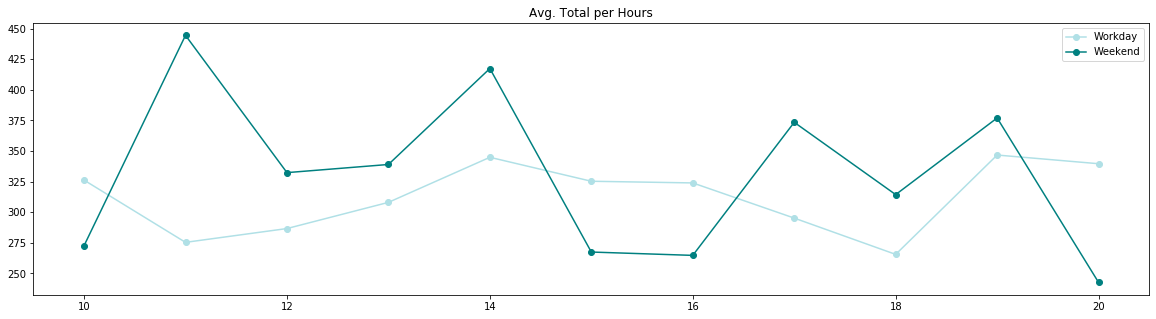

In [12]:
fig, axs = plt.subplots(figsize = (20, 5))
plt.plot('Workday', data = total, linestyle='-', marker='o', color = 'powderblue')
plt.plot('Weekend', data = total, linestyle='-', marker='o', color = 'teal')
plt.legend()
plt.title('Avg. Total per Hours')

plt.show()

### Ratings

In [15]:
work_cross = pd.pivot_table(index = 'Hour', values = 'Rating', columns = 'Weekday', 
                            data = retail, aggfunc = 'mean', margins = True)
work_cross

Weekday,Weekend,Workday,All
Hour,,,
10,6.507407,7.357812,7.105495
11,6.700000,6.909091,6.847436
12,7.689655,7.271739,7.433333
13,7.415625,7.041176,7.185542
14,7.312500,6.691837,6.895890
15,6.300000,7.046774,6.844706
16,6.965000,6.851064,6.885075
17,6.773913,6.965854,6.896875
18,7.148485,7.395349,7.288158


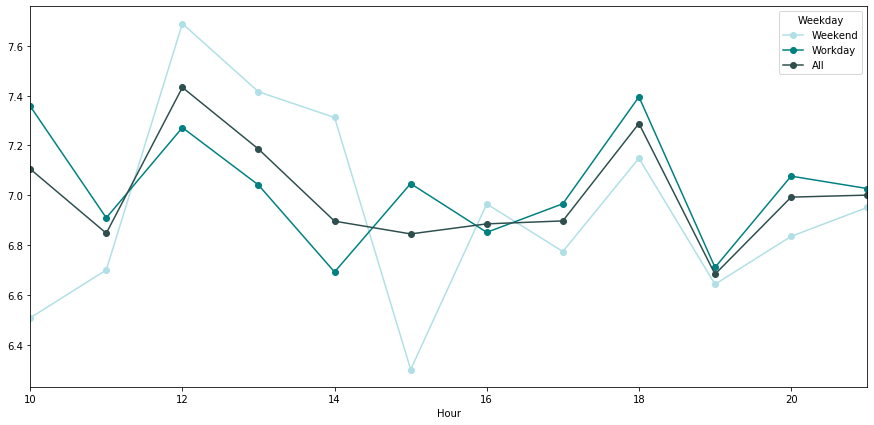

In [22]:
work_cross.plot(figsize=(15,7), linestyle='-', marker = 'o', color = ['powderblue', 'teal', 'darkslategrey'])
plt.show()